In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
from scipy.interpolate import interp2d
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import torch.nn.init as init

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
class Network(nn.Module):

  def __init__(self):
    super().__init__()
    # optimisers    

    # constants and stuff
    device = 'cuda'
    self.N = 500
    self.N_data = 500
    self.r0_boundary, self.rs_boundary, self.t_boundaries, self.t0_boundary, self.r_boundary = self.init_boundaries(self.N)
    self.r_data, self.t_data = self.sample(self.N_data)
    self.c_numerical = torch.tensor(self.NumericalSoln(self.r_data.cpu().detach().numpy(), self.t_data.cpu().detach().numpy())).to(device)
    self.j = -5.35e-5
    self.Rs_ye = torch.tensor(2e-6).requires_grad_(True).to(device)
    self.Rs = torch.tensor(2e-6)
    self.c_max = 4.665e4
    self.c_max_ye = torch.tensor(4.665e4).requires_grad_(True).to(device)
    self.c0 = torch.tensor(2e4).view(-1, 1).to(device)
    self.D_ref = 2e-16
    self.C_theory = 277.84
    self.C_practical = 160
    self.t_max_ye = torch.tensor(400.).requires_grad_(True).to(device)

    # storing D and loss values
    self.Ds = []
    self.loss_list = []
    self.r0_loss_list = []
    self.rs_loss_list = []
    self.phys_loss_list = []
    self.comp_loss_list = []

    # nn constants
    activation = nn.SELU
    D_activation = nn.Tanh
    self.D_hidden = 16 # number of neurons in hidden layers for D
    self.D_layers = 5 # number of hidden layers for D
    self.input = 2 # input is r and t
    self.output = 1 # output is c
    self.layers = 10 # number of hidden layers
    self.hidden = 128 # number of neurons in hidden layers

    # c network
    self.fci = nn.Sequential(*[nn.Linear(self.input, self.hidden), activation()])
    init.kaiming_normal_(self.fci[0].weight, nonlinearity='tanh')
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.hidden, self.hidden), activation()]) for i in range(self.layers-1)])
    for layer in self.fch.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight, nonlinearity='tanh')
    self.fco = nn.Linear(self.hidden, self.output)

    # D network
    self.fciD = nn.Sequential(*[nn.Linear(1, self.D_hidden), D_activation()])
    init.kaiming_normal_(self.fciD[0].weight)
    self.fchD = nn.Sequential(*[nn.Sequential(*[nn.Linear(self.D_hidden, self.D_hidden), D_activation()]) for i in range(self.D_layers-1)])
    for layer in self.fchD.children():
      if isinstance(layer, nn.Linear):
          init.kaiming_normal_(layer.weight)
    self.fcoD = nn.Linear(self.D_hidden, 1)

  # c forward propagation
  def forward_c(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    x = self.c0/self.c_max + t**2*x
    return x
  
  # D forward propagation
  def forward_D(self, x):
    x = self.fciD(x)
    x = self.fchD(x)
    x = self.fcoD(x)
    x = x*1e-13
    return x
  
  # numerical solution of spherical diffusion equation
  def NumericalSoln(self, r_data, t_data):

    numerical_sol = pd.read_csv("MATLAB Solver\data.csv")
    
    sol = []
    for i in range(len(r_data)):
      r = np.round(9999 * r_data[i]).astype(int)[0]
      t = np.round(399 * t_data[i]).astype(int)[0]  
      
      c = numerical_sol.iloc[r, t]
      sol.append(c)
    return sol
  
  def init_boundaries(self, N):

    # x and t boundary points for training x boundaries, x = 0,1, varying t values
    r0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    rs_boundary = torch.tensor(1.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    t_boundaries = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    # 0 time boundary for training
    t0_boundary = torch.tensor(0.).repeat(N).view(-1, 1).requires_grad_(True).to(device)
    r_boundary = torch.rand(N).view(-1, 1).requires_grad_(True).to(device)

    return r0_boundary, rs_boundary, t_boundaries, t0_boundary, r_boundary

  def sample(self, N):
        
    # sample points for training
    r = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)
    t = torch.rand(N).view(-1, 1).requires_grad_(True).to(device).view(-1, 1)

    return r, t

# adaptive sampling, unused due to VRAM limitations
  def adaptive_sample(self, N):
    
    r = torch.linspace(0.0001, 1, 2*N).requires_grad_(True).to(device)
    t = torch.linspace(0.0001, 1, 2*N).requires_grad_(True).to(device)
    r_grid, t_grid = torch.meshgrid(r, t)
    phys_loss = self.phys_loss(r_grid.flatten().unsqueeze(1), t_grid.flatten().unsqueeze(1))

    ids = torch.multinomial(phys_loss, N, replacement=True)
    r = r[ids]
    t = t[ids]

    print(r.shape, t.shape)

    return r, t

  def Diffusion_Coeff(self, c):

    SOC = (self.c_max - c)/self.c_max * self.C_theory/self.C_practical
    D = self.D_ref * (1 + 100*SOC**(3/2))

    return D
  
  def deriv_t(self, c, t):
    return torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def deriv_r(self, c, r):
    return torch.autograd.grad(c, r, grad_outputs=torch.ones_like(c).to(device), create_graph=True)[0]
  
  def phys_loss(self, r, t):

    Rs = self.Rs
    c = self.forward_c(r, t)
    c_r = self.deriv_r(c, r)
    c_rr = self.deriv_r(c_r, r)
    c_t = self.deriv_t(c, t)
    D = self.forward_D(c)
    D_r = self.deriv_r(D, r)
    term = r**2*D*c_r/(Rs**2)
    deriv = self.deriv_r(term, r)

    #loss = (r**2*c_t - (2*r*c_r - D*r**2*c_rr - D_r*r**2*c_r)/(Rs**2))**2
    loss = (r**2*c_t - deriv)**2
    return loss

  def losses(self):
    
    r_phys, t_phys = self.sample(self.N)
    j, Rs, c_max, c0 = self.j, self.Rs, self.c_max, self.c0 

    # loss for r = 0 boundary
    c = self.forward_c(self.r0_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.r0_boundary)
    r0_loss = c_r**2
    self.r0_loss_list.append(torch.mean(r0_loss).item())
    
    # loss for x = rs boundary
    c = self.forward_c(self.rs_boundary, self.t_boundaries)
    c_r = self.deriv_r(c, self.rs_boundary)
    D = self.forward_D(c)
    rs_loss = (D*c_r + j*Rs/c_max)**2
    self.rs_loss_list.append(torch.mean(rs_loss).item())

    # physics loss
    phys_loss = self.phys_loss(r_phys, t_phys)
    self.phys_loss_list.append(torch.mean(phys_loss).item())
    
    # comparative loss
    c = self.c_max*self.forward_c(self.r_data, self.t_data)
    comp_loss = 1/self.c_max*(torch.sub(c, self.c_numerical.unsqueeze(1)))**2
    self.comp_loss_list.append(torch.mean(comp_loss).item())

    loss = 100*torch.mean(comp_loss) + torch.mean(r0_loss) + 1e28*torch.mean(rs_loss) + torch.mean(phys_loss)
    #  + 
    print(f'epoch: {self.epoch}, pde loss: {100*torch.mean(phys_loss).item()}, r0 loss: {torch.mean(r0_loss).item()}, rs loss: {1e28*torch.mean(rs_loss).item()}, comp loss:{torch.mean(comp_loss).item()})', end='\r')


    return loss
  
  def closure(self):
    self.optimizer_lbfgs.zero_grad()
    loss = self.losses()
    loss.backward()
    return loss
  
  def train(self, epochs_adam, lr_adam, epochs_lbfgs):

    # Adam
    optimizer_adam = torch.optim.Adam(self.parameters(), lr = lr_adam)
    for epoch in range(epochs_adam):

      self.epoch = epoch
      
      optimizer_adam.zero_grad()
      loss = self.losses()
      self.loss_list.append(loss.item())
      loss.backward()
      #torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
      optimizer_adam.step()
      #print(f'Epoch: {epoch}  Loss: {loss.item()}', end='\r')

    # LBFGS
    self.optimizer_lbfgs = torch.optim.LBFGS(self.parameters(), 
                                        max_iter=400, 
                                        history_size=400, 
                                        tolerance_grad=1.0 * np.finfo(float).eps, 
                                        tolerance_change=1.0 * np.finfo(float).eps, 
                                        line_search_fn='strong_wolfe')
    for epoch in range(epochs_lbfgs):

      self.loss_list.append(loss.item())
      loss = self.optimizer_lbfgs.step(self.closure)

      self.epoch = epochs_adam + epoch

      #print(f'Epoch: {epochs_adam + epoch}  Loss: {loss.item()}', end='\r')

    self.plot()
    error_D = self.plot_D()
    self.plot_loss()
    self.plot_comparison()
    error_c = self.error()

    return self.loss_list, error_D, error_c

  def plot(self):

      X = torch.linspace(0, 1, 100).to(device)
      T = torch.linspace(0, 1, 100).to(device)
      X_grid, T_grid = torch.meshgrid(X, T)
      
      C = self.c_max*self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100)
      C = C.cpu().detach().numpy()
      
      X, T = np.meshgrid(self.Rs*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy())

      fig = go.Figure(data=[go.Surface(z=C, x=X, y=T)])
      fig.update_layout(template = 'plotly_dark', 
                        title='Concentration vs Time and Radius', 
                        scene = dict(xaxis = dict(title = 'Radius'),
                        yaxis = dict(title = 'Time (s)'),
                        zaxis = dict(title = 'Concentration')),                        
                        autosize=False, width=800, height=600, margin=dict(l=50, r=50, t=50, b=50))
      fig.show()

  def plot_D(self):

    c = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    D = self.forward_D(c).cpu().detach().numpy()
    c = self.c_max*c.cpu().detach().numpy()
    D_SOC = self.Diffusion_Coeff(c)

    error_D = np.mean(np.sqrt((D - D_SOC)**2))

    plt.plot(c.flatten(), D.flatten(), label='Diffusion Coefficient Network', color='blue')
    plt.plot(c.flatten(), D_SOC.flatten(), label='Diffusion Coefficient Analytical', color='red')

    # Set plot title and labels
    plt.title('Diffusion Coefficient vs Concentration')
    plt.xlabel('Concentration')
    plt.ylabel('Diffusion Coefficient')
    plt.yscale('log')

    # Add legend
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

    return error_D

  def plot_loss(self):
    fig = px.scatter(
            x=range(len(self.loss_list)),
            y=self.loss_list,
            log_y=True,
            log_x=True,
            color=np.log(self.loss_list),
            color_continuous_scale="Agsunset",
            labels={"x": "Epochs", "y": "Loss"},
            template='plotly_dark'
        )
    fig.show()

    # Create a figure and subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))

    # Plot r0_loss
    axs[0].plot(self.r0_loss_list, label='r0_loss')
    axs[0].set_ylabel('r0_loss')
    axs[0].set_yscale('log')  
    axs[0].set_xlabel('Epochs')
    axs[0].set_title('R0 Loss vs Epochs')
    axs[0].grid(True)

    # Plot rs_loss
    axs[1].plot(self.rs_loss_list, label='rs_loss')
    axs[1].set_ylabel('rs_loss')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Epochs')
    axs[1].set_title('Rs Loss vs Epochs')
    axs[1].grid(True)

    # Plot phys_loss
    axs[2].plot(self.phys_loss_list, label='phys_loss')
    axs[2].set_xlabel('Epochs')
    axs[2].set_yscale('log')
    axs[2].set_ylabel('phys_loss')
    axs[2].set_title('Physics Loss vs Epochs')
    axs[2].grid(True)

    # Plot comp_loss
    axs[3].plot(self.comp_loss_list, label='comp_loss')
    axs[3].set_xlabel('Epochs')
    axs[3].set_yscale('log')
    axs[3].set_ylabel('comp_loss')
    axs[3].set_title('Comparative Loss vs Epochs')
    axs[3].grid(True)
    
    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

  def plot_comparison(self):
      numerical = pd.read_csv("MATLAB Solver\data.csv")
      X = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
      T = torch.linspace(0, 1, 100).to(device).requires_grad_(True)
      X_grid, T_grid = torch.meshgrid(X, T)

      C = self.c_max * self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
      C = C.view(100, 100).cpu().detach().numpy()

      X = np.linspace(0, 2e-6, 100)
      X_numerical = np.linspace(0, 2e-6, 10000)
      T = np.linspace(0, 400, 100)
      T_numerical = np.linspace(0, 400, 401)

      fig, axs = plt.subplots(2, 2, figsize=(10, 10))

      axs[0, 0].plot(X, C[:, 0], label='NN', color="blue", marker = 'o',markevery=10)
      axs[0, 0].plot(X_numerical, numerical.iloc[:, 0], label='Numerical', color="red")
      axs[0, 0].set_title('Comparison at t=0')
      axs[0, 0].set_xlabel('R (m)')
      axs[0, 0].set_ylabel('Concentration (mol/m³)')
      axs[0, 0].legend()

      axs[0, 1].plot(X, C[:, -1], label='NN', color="blue", marker = 'o',markevery=10)
      axs[0, 1].plot(X_numerical, numerical.iloc[:, -1], label='Numerical', color="red")
      axs[0, 1].set_title('Comparison at t=end')
      axs[0, 1].set_xlabel('R (m)')
      axs[0, 1].set_ylabel('Concentration (mol/m³)')

      axs[1, 0].plot(T, C[0, :], label='NN', color="blue", marker = 'o',markevery=10)
      axs[1, 0].plot(T_numerical, numerical.iloc[0, :], label='Numerical', color="red")
      axs[1, 0].set_title('Comparison at r=0')
      axs[1, 0].set_xlabel('T (s)')
      axs[1, 0].set_ylabel('Concentration (mol/m³)')

      axs[1, 1].plot(T, C[-1, :], label='NN', color="blue", marker = 'o',markevery=10)
      axs[1, 1].plot(T_numerical, numerical.iloc[-1, :], label='Numerical', color="red")
      axs[1, 1].set_title('Comparison at r=end')
      axs[1, 1].set_xlabel('T (s)')
      axs[1, 1].set_ylabel('Concentration (mol/m³)')

      plt.tight_layout()
      plt.show()
      
  def error(self):
    
    X = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    T = torch.linspace(0, 0.99, 101).to(device).requires_grad_(True)
    X_grid, T_grid = torch.meshgrid(X, T)
    C = self.forward_c(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1))
    C = self.c_max*C.view(101, 101)
    X_int = np.round(9999*X.cpu().detach().numpy()).astype(int)
    T_int = np.round(399*T.cpu().detach().numpy()).astype(int)

    numerical = pd.read_csv("MATLAB Solver\data.csv").to_numpy()
    numerical = numerical[np.ix_(X_int, T_int)]
    error = np.absolute(numerical - C.cpu().detach().numpy())/numerical*100
    abs_error = np.mean(np.sqrt((numerical - C.cpu().detach().numpy())**2))



    phys_loss = self.phys_loss(X_grid.flatten().unsqueeze(1), T_grid.flatten().unsqueeze(1)).view(101, 101).cpu().detach().numpy()

    fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(12, 12))

    X, T = self.Rs*10000*X.cpu().detach().numpy(), 400*T.cpu().detach().numpy()

      # Numerical plot
    cs0 = axs[0, 0].contourf(X, T, numerical.T, levels = 15)  # Transpose numerical data
    fig.colorbar(cs0, ax=axs[0, 0], label='Concentration (mol/m³)')
    axs[0, 0].set_title('Numerical Solution')
    axs[0, 0].set_xlabel('T (s)')  # Swap x and y labels
    axs[0, 0].set_ylabel('R (m)')  # Swap x and y labels
    #axs[0].legend()

    # C against X and T
    cs1 = axs[0, 1].contourf(X, T, C.cpu().detach().numpy().T, levels = 15)  # Transpose C data
    fig.colorbar(cs1, ax=axs[0, 1], label='Concentration (mol/m³)')
    axs[0, 1].set_title('Neural Network Solution')
    axs[0, 1].set_xlabel('T (s)')  # Swap x and y labels
    axs[0, 1].set_ylabel('R (m)')  # Swap x and y labels
    #axs[1].legend()
    # Error Surface
    cs2 = axs[1, 0].contourf(X, T, error.T, cmap = 'magma')  # Transpose error data
    fig.colorbar(cs2, ax=axs[1, 0], label='Error %')
    axs[1, 0].set_title('Error Surface')
    axs[1, 0].set_xlabel('T (s)')  # Swap x and y labels
    axs[1, 0].set_ylabel('R (m)')  # Swap x and y labels

    # Physical Loss Surface
    cs3 = axs[1, 1].contourf(X, T, phys_loss.T, cmap = 'magma')  # Transpose phys_loss data
    fig.colorbar(cs3, ax=axs[1, 1], label='Physical Loss')
    axs[1, 1].set_title('Physical Loss Surface')
    axs[1, 1].set_xlabel('T (s)')  # Swap x and y labels
    axs[1, 1].set_ylabel('R (m)')  # Swap x and y labels

    plt.tight_layout()

    return abs_error
    


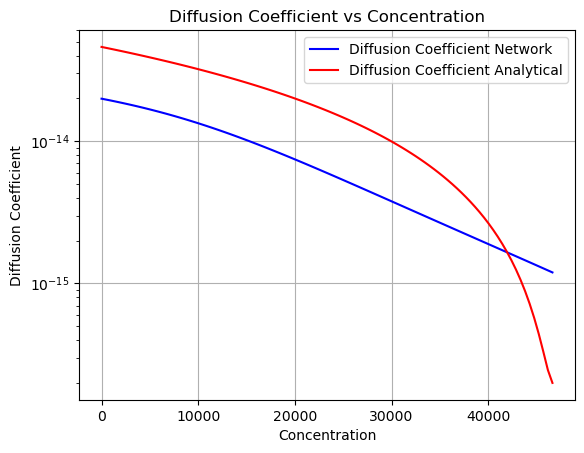

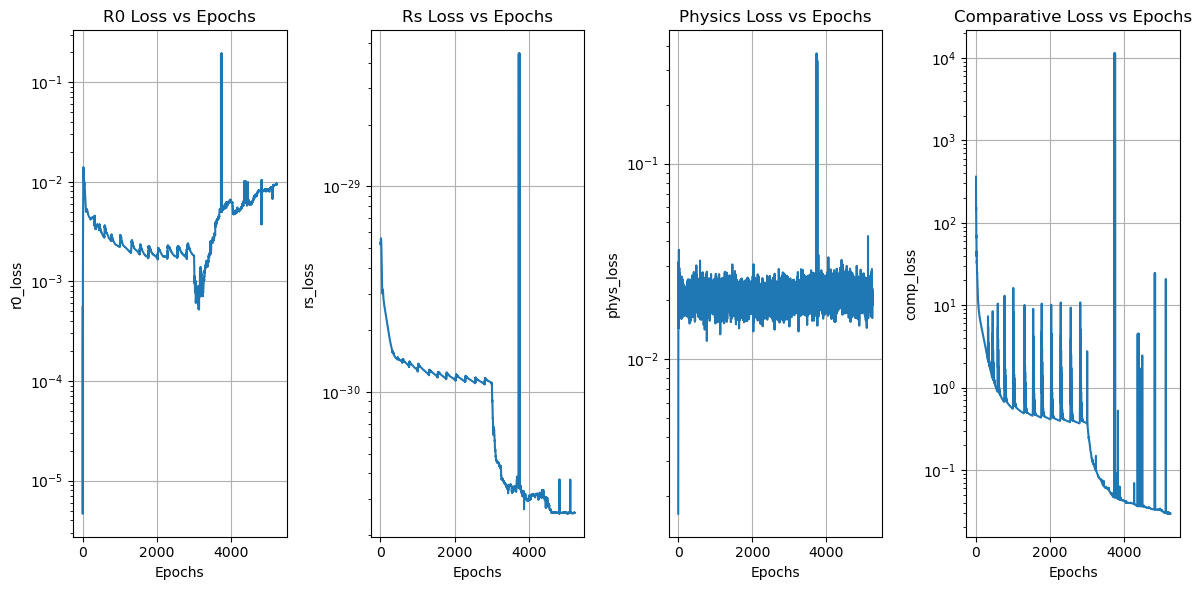

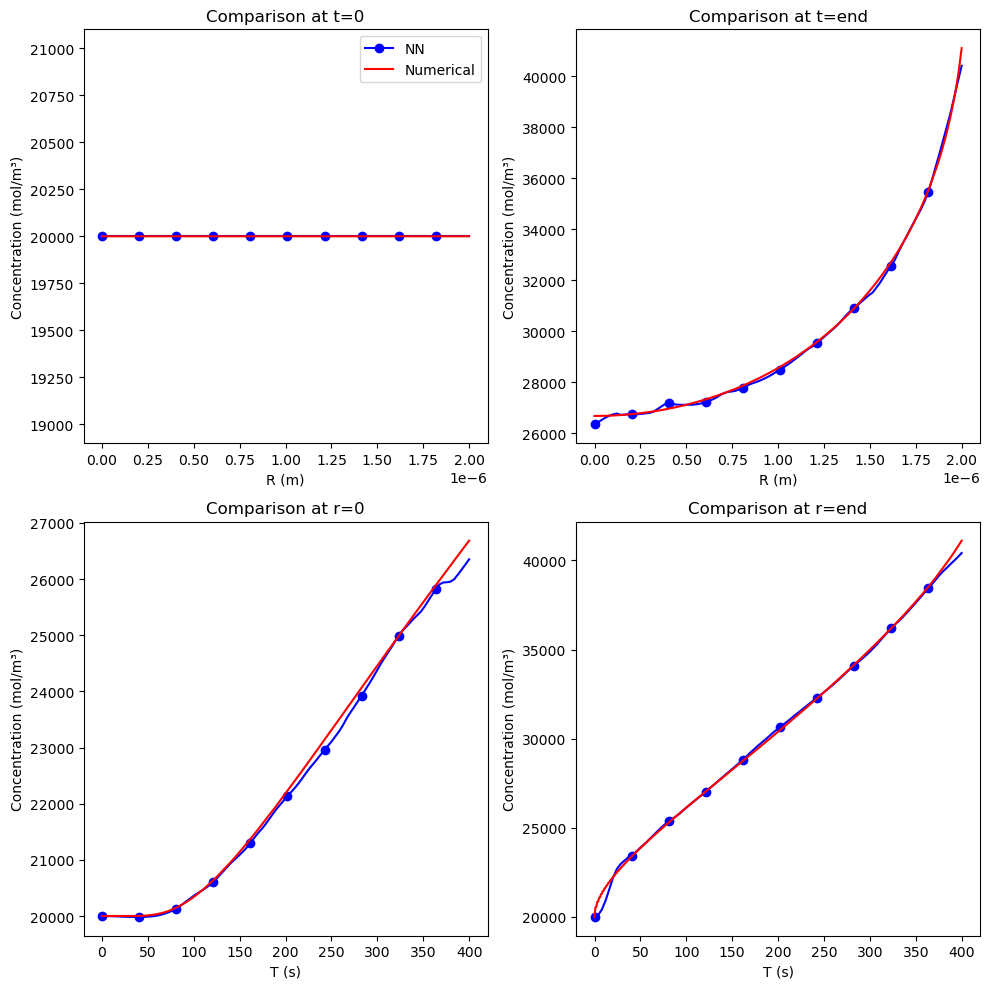

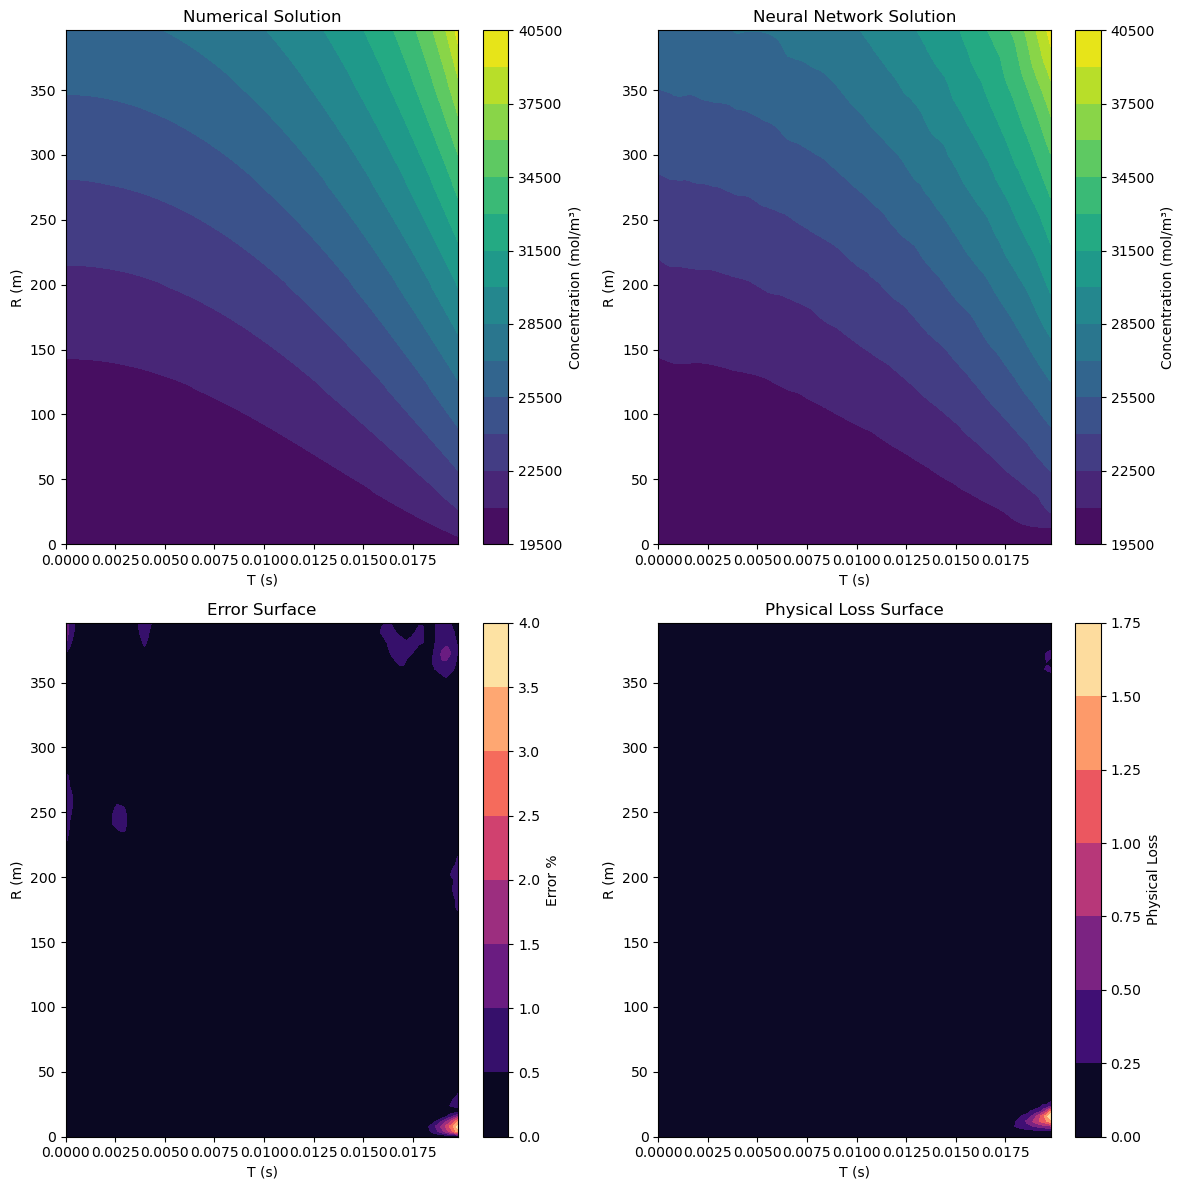

In [36]:
# nn seed
device = 'cuda'
N = 300
epochs_adam = 3000
lr_adam = 1e-4
epochs_lbfgs = 100


# define nn to train, two inputs for x and t
pinn = Network().to(device)


losses = pinn.train(epochs_adam, lr_adam, epochs_lbfgs)